In [1]:
import numpy as np
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

In [2]:
def set_seed(seed):
    np.random.seed(seed) 
    torch.manual_seed(seed)  
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  
        torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 

seed = 0
set_seed(seed)

In [3]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return np.real(deriv)


In [4]:

n = 400
m = 400


x = np.linspace(-4,4,n+1)[:-1]
dx = x[1]-x[0]
t = np.linspace(0,10,m)
dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d=dx)

u0 = np.exp(-(x+1)**2)

params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T
u = u + 0.1 * np.std(u) * np.random.randn(n, m)

X, T = np.meshgrid(x, t, indexing='ij')
u_flattened = u.flatten()[:, np.newaxis]
T_flattened = T.flatten()[:, np.newaxis]
input = np.vstack([X.flatten(), T.flatten()]).T

print("input shape:", input.shape)
print("u_flattened shape:", u_flattened.shape)

u_xx_true = 0.01*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

input shape: (160000, 2)
u_flattened shape: (160000, 1)


In [5]:
points_r = 800
input_shape = input.shape[0]
random_indices = np.random.choice(input_shape, size=points_r, replace=False)

# Selecting points based on indices
input_r = input[random_indices, :]
U = u_flattened[random_indices, :]
tt = T_flattened[random_indices, :]
print(input_r.shape, U.shape)

(800, 2) (800, 1)


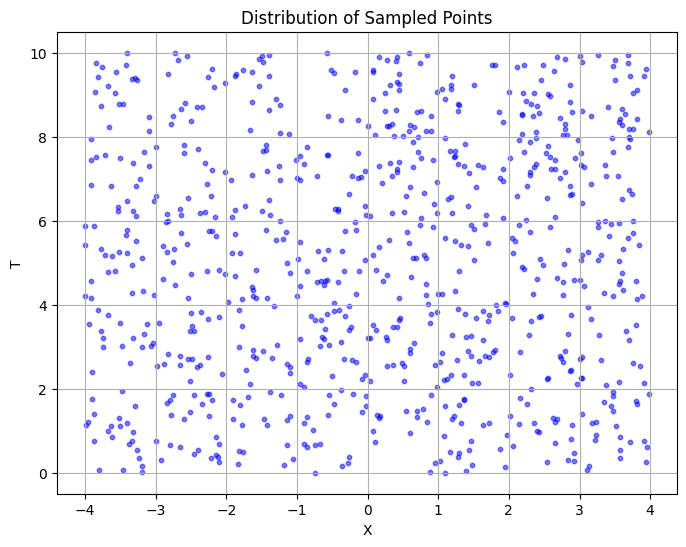

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(input_r[:, 0], input_r[:, 1], c='blue', marker='o', s=10, alpha=0.5)
plt.title('Distribution of Sampled Points')
plt.xlabel('X')
plt.ylabel('T')
plt.grid(True)
plt.show()


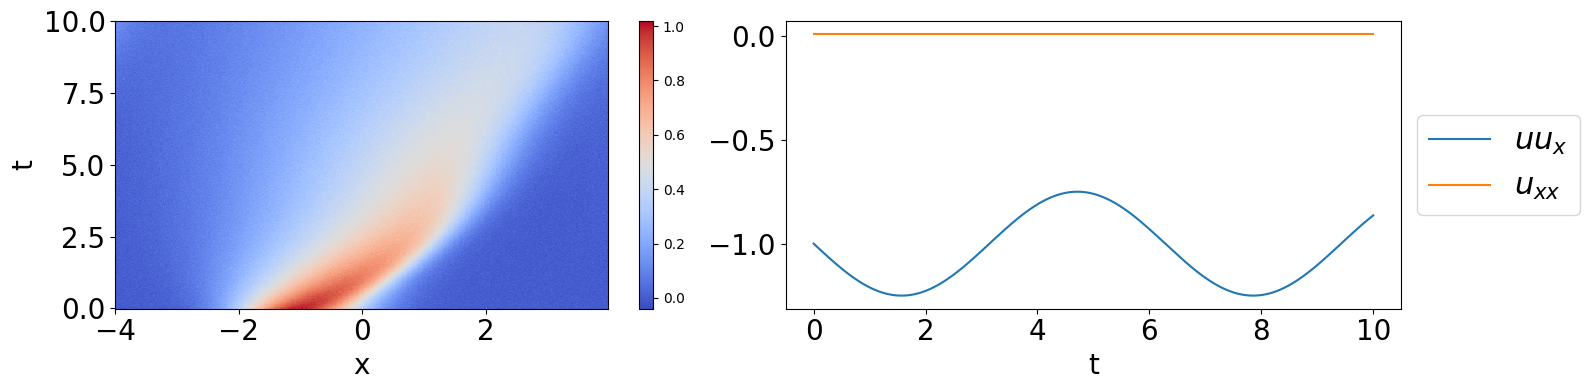

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

fontsize = 20
X, T = np.meshgrid(x, t)
c = axes[0].pcolormesh(X, T, u.T, cmap=cm.coolwarm)
axes[0].set_xlabel('x', fontsize=fontsize)
axes[0].set_ylabel('t', fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)
axes[0].set_xlim([x[0], x[-1]])
fig.colorbar(c, ax=axes[0])

axes[1].plot(t, uu_x_true, label=r'$uu_{x}$')
axes[1].plot(t, u_xx_true, label=r'$u_{xx}$')
axes[1].set_xlabel('t', fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize+2)

fig.tight_layout()
plt.show()

In [8]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from reskan import *
import torch

In [9]:
x_range = [-4,4]
t_range = [0,10]
x_steps = 100
t_steps = 175
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:

x_k = torch.linspace(x_range[0], x_range[1], x_steps, device=device)  # (x_steps,)
t_k = torch.linspace(t_range[0], t_range[1], t_steps, device=device)  # (t_steps,)

X_k, T_k = torch.meshgrid(x_k, t_k, indexing='xy')

X_pde_flat = X_k.reshape(-1, 1)
T_pde_flat = T_k.reshape(-1, 1)

input_k = torch.cat([X_pde_flat, T_pde_flat], dim=1).requires_grad_(True)
input_r = torch.from_numpy(input_r).requires_grad_(True).to(device)
tt = torch.from_numpy(tt).requires_grad_(True).to(device)
U = torch.from_numpy(U).requires_grad_(True).to(device)

input_r = input_r.float()
input_k = input_k.float()
U = U.float()

print(tt.shape, input_r.shape, U.shape, input_k.shape)

torch.Size([800, 1]) torch.Size([800, 2]) torch.Size([800, 1]) torch.Size([17500, 2])


In [11]:
rhs_des = [
    '',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}',
 'uu_{x}',
 'u_{xxx}'
 ]

In [12]:
Nd = 50 
Nh = 3  
Nb = 4   

model = VC_PIKAN(Nd=Nd, Nh=Nh, Nb=Nb, rhs_des=rhs_des, range_x=x_range, range_t=t_range, seed=6666, device=device)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


  0%|          | 0/300 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 300/300 [43:41<00:00,  8.74s/it, loss=-7.78, loss_data=0.000368, loss_pde=0.000138, loss_reg=0.365]


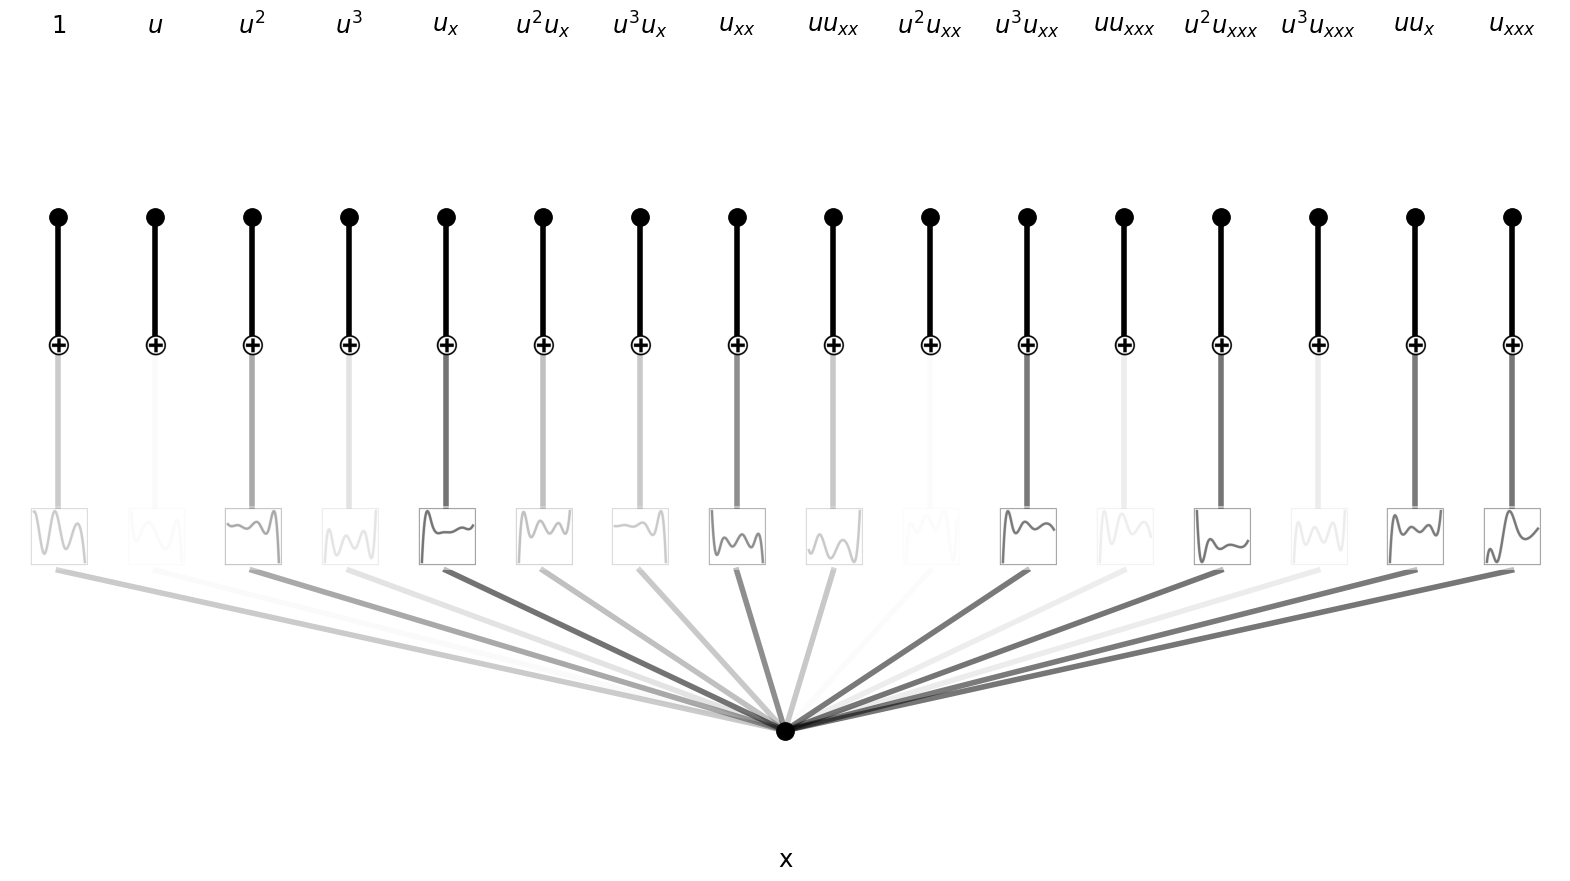

In [13]:
model.fit(input_r, input_k, U, steps=300, alpha=0.1, lam=0.001, lamb_l1=1., lamb_coef=0.5, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all', save_fig=True, img_folder='./tem_file')
model.kan_plot()

In [14]:
torch.save(model.state_dict(), 'burgers.pt')

Original:


After pruning:
saving model version 0.2


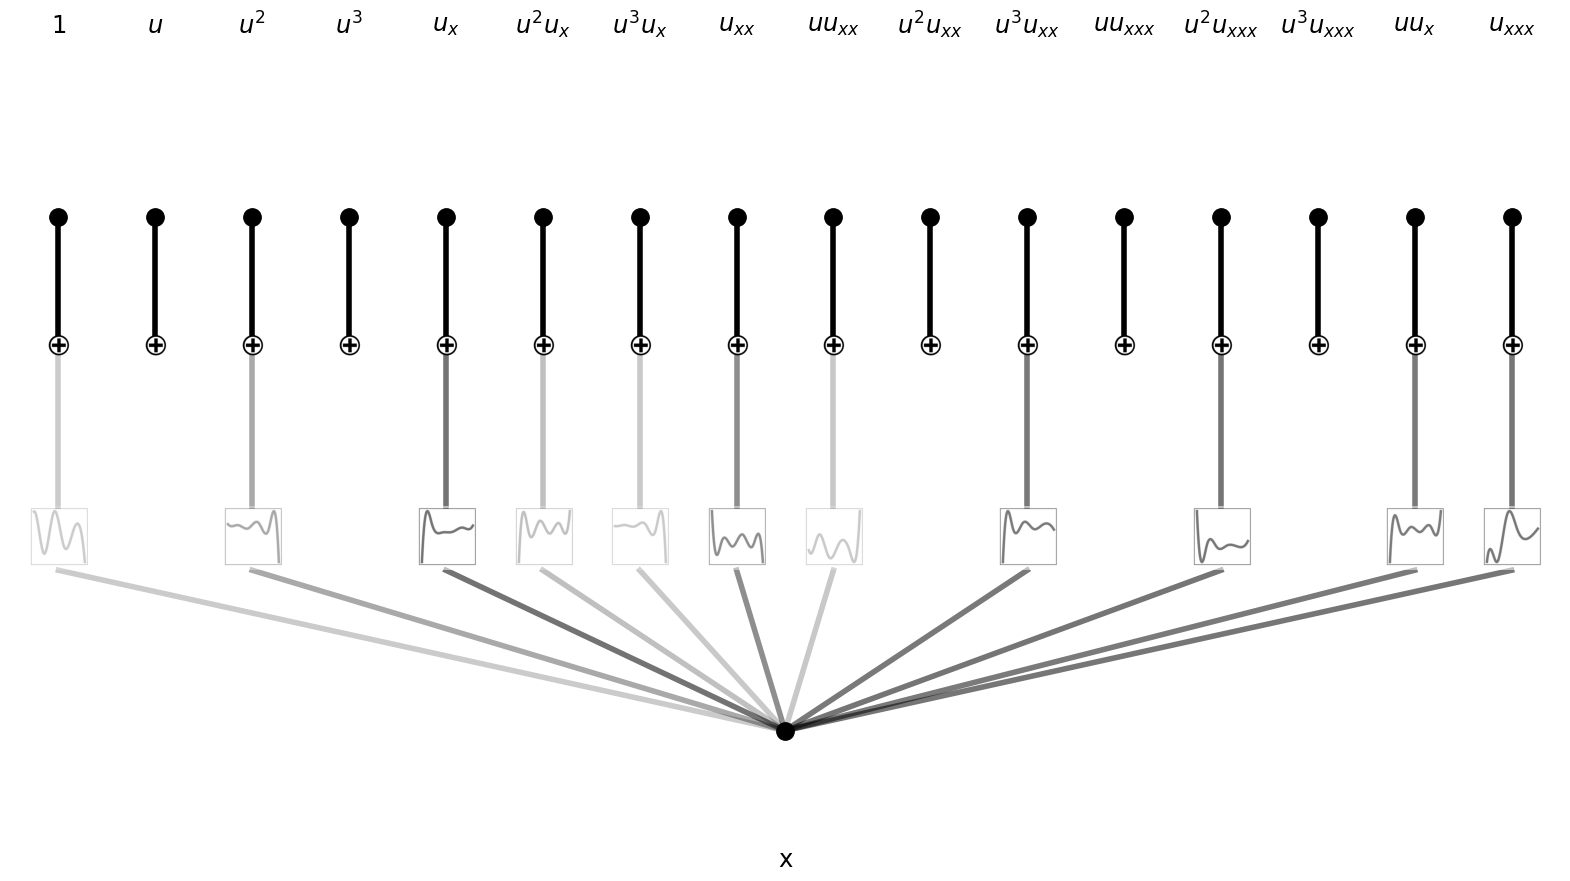

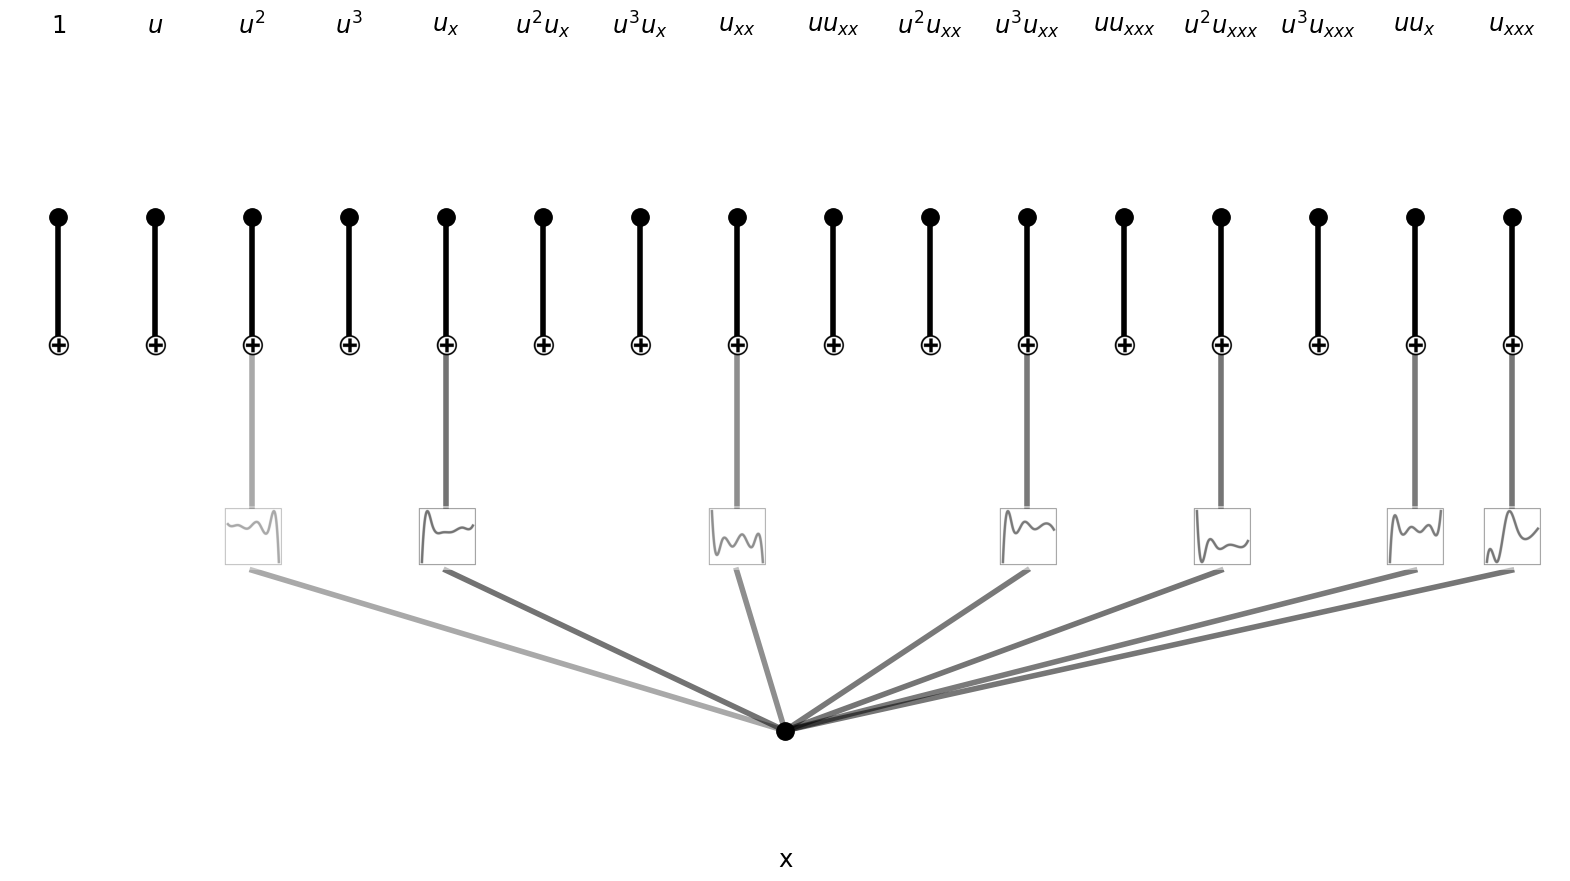

In [17]:
model.prune_kan(input_k)

saving model version 0.4


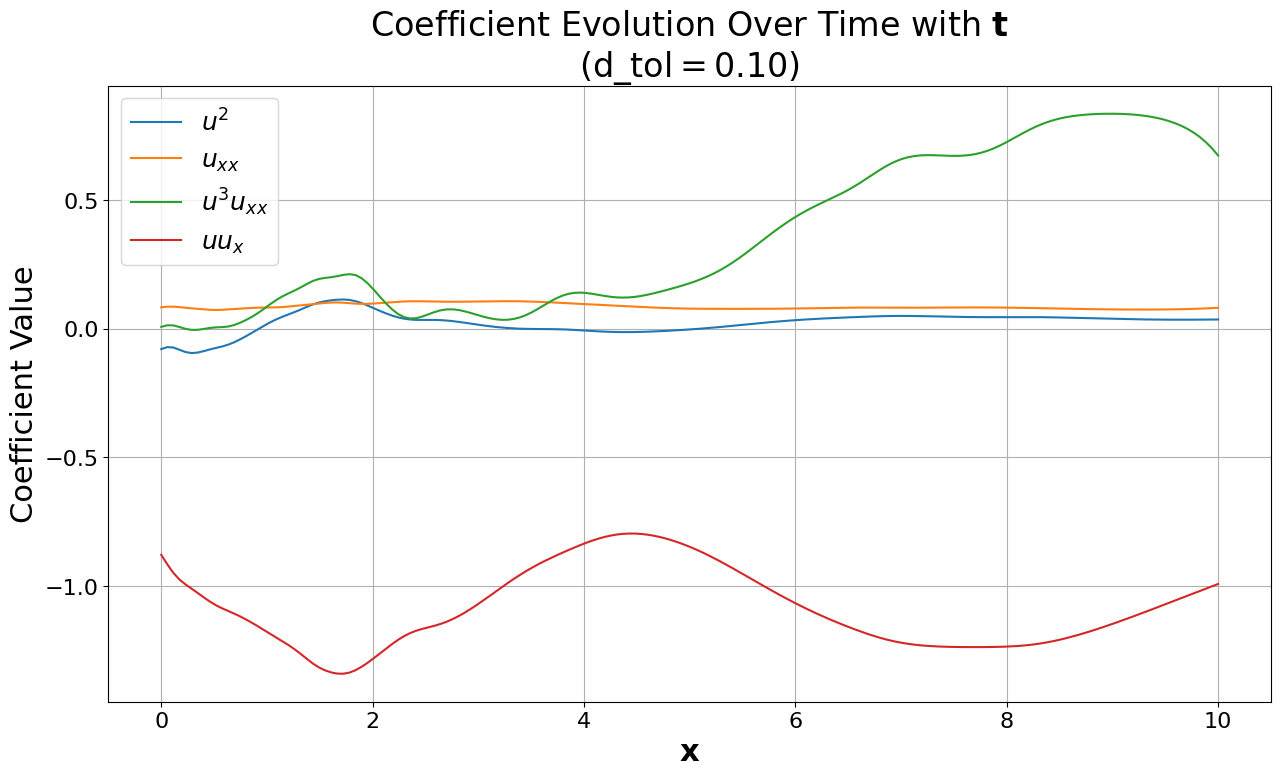

Plot saved as vc_plot/burgers_iter1.pdf


In [19]:
lam = 1e-6
d_tol = 0.1
model.G_STRidge(input_k=input_k, x_steps=x_steps, t_steps=t_steps, d_tol=d_tol, lam=lam)
t = torch.linspace(0,10,t_steps)
model.ridge_plot(d_tol, t, filename='burgers_iter1')

saving model version 0.5
saving model version 0.6
saving model version 0.7


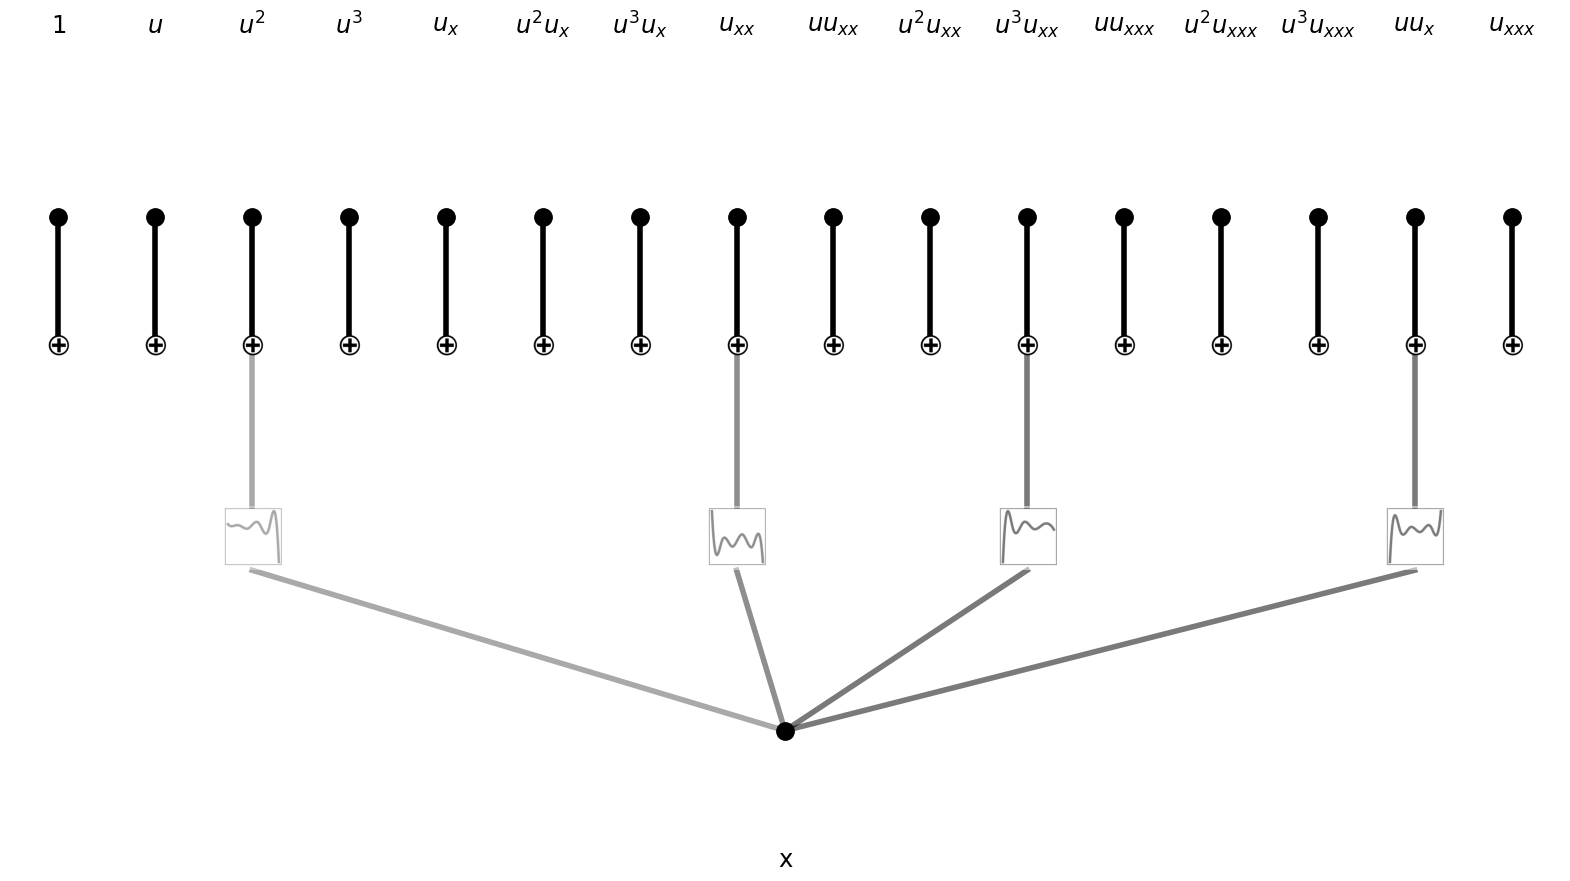

In [20]:
model.active_remove_edge(4)
model.active_remove_edge(12)
model.active_remove_edge(15)
model.kan_plot()

  0%|          | 0/200 [00:00<?, ?it/s]

Training on cuda


 34%|███▍      | 69/200 [08:33<16:15,  7.45s/it, loss=-7.2, loss_data=0.000382, loss_pde=0.000288, loss_reg=0.336] 


KeyboardInterrupt: 

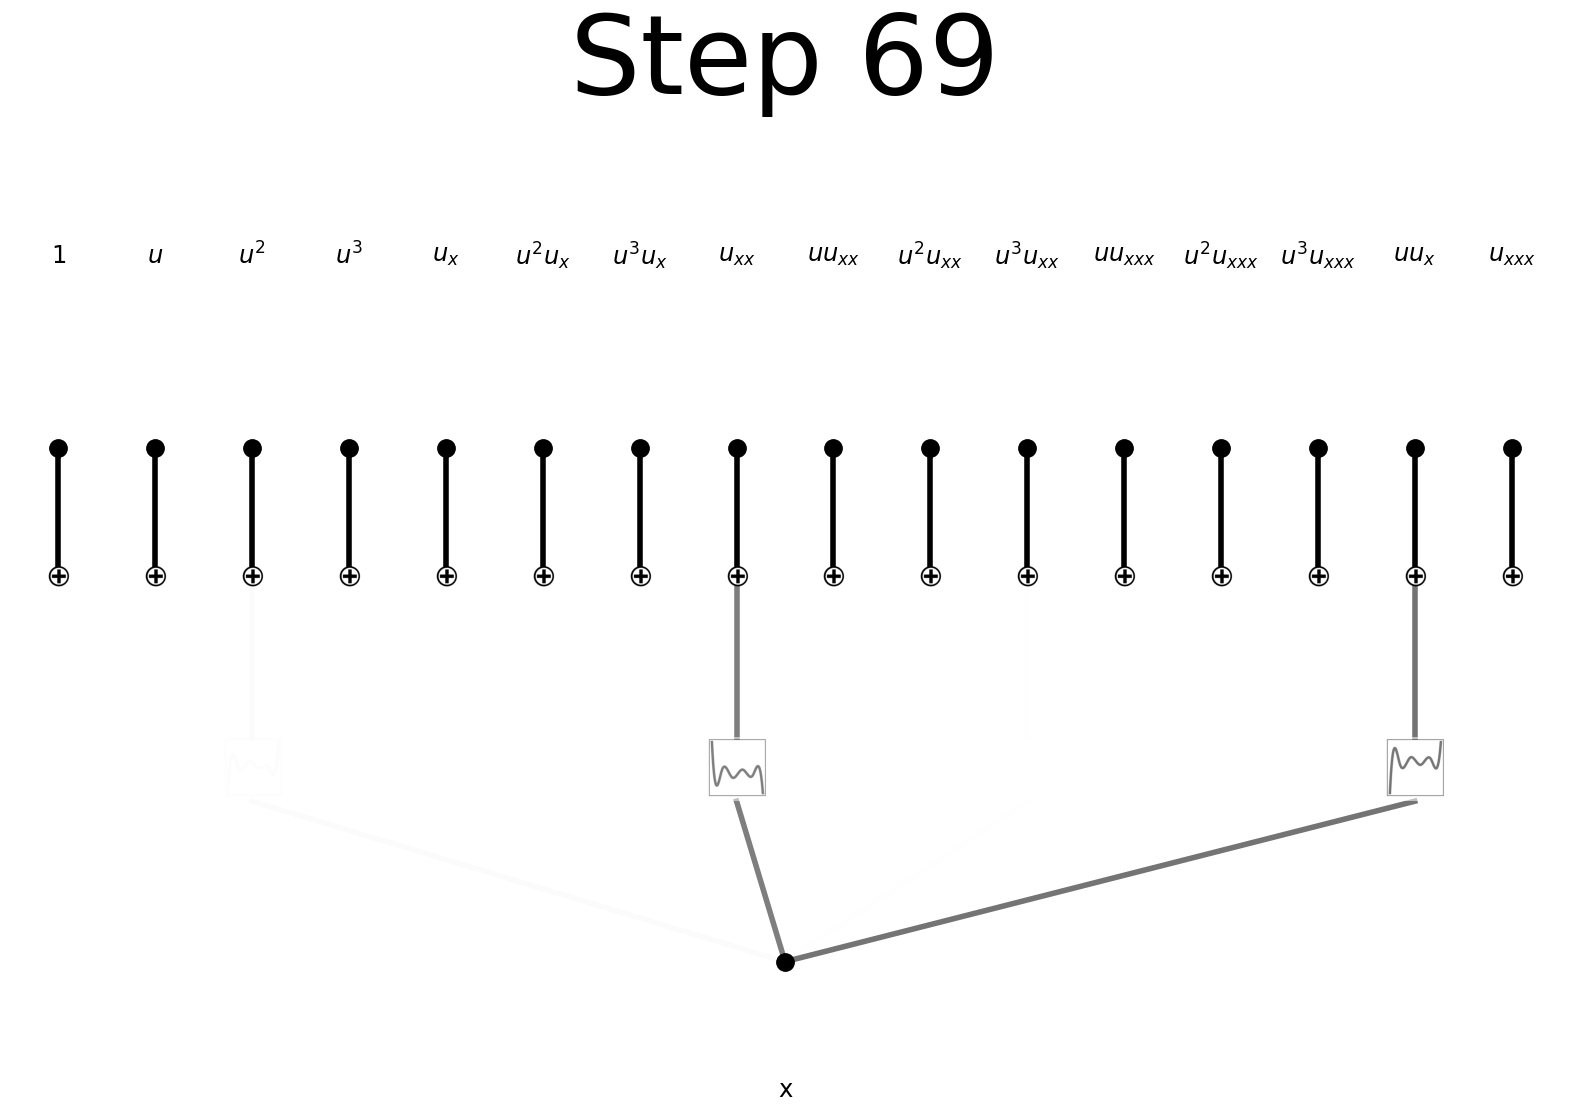

In [21]:
model.fit(input_r, input_k, U, steps=200, alpha=0.1, lam=0.01, lamb_l1=1., lamb_coef=1, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all', save_fig=True, img_folder='./tem_file2')

Original:


After pruning:
saving model version 0.1


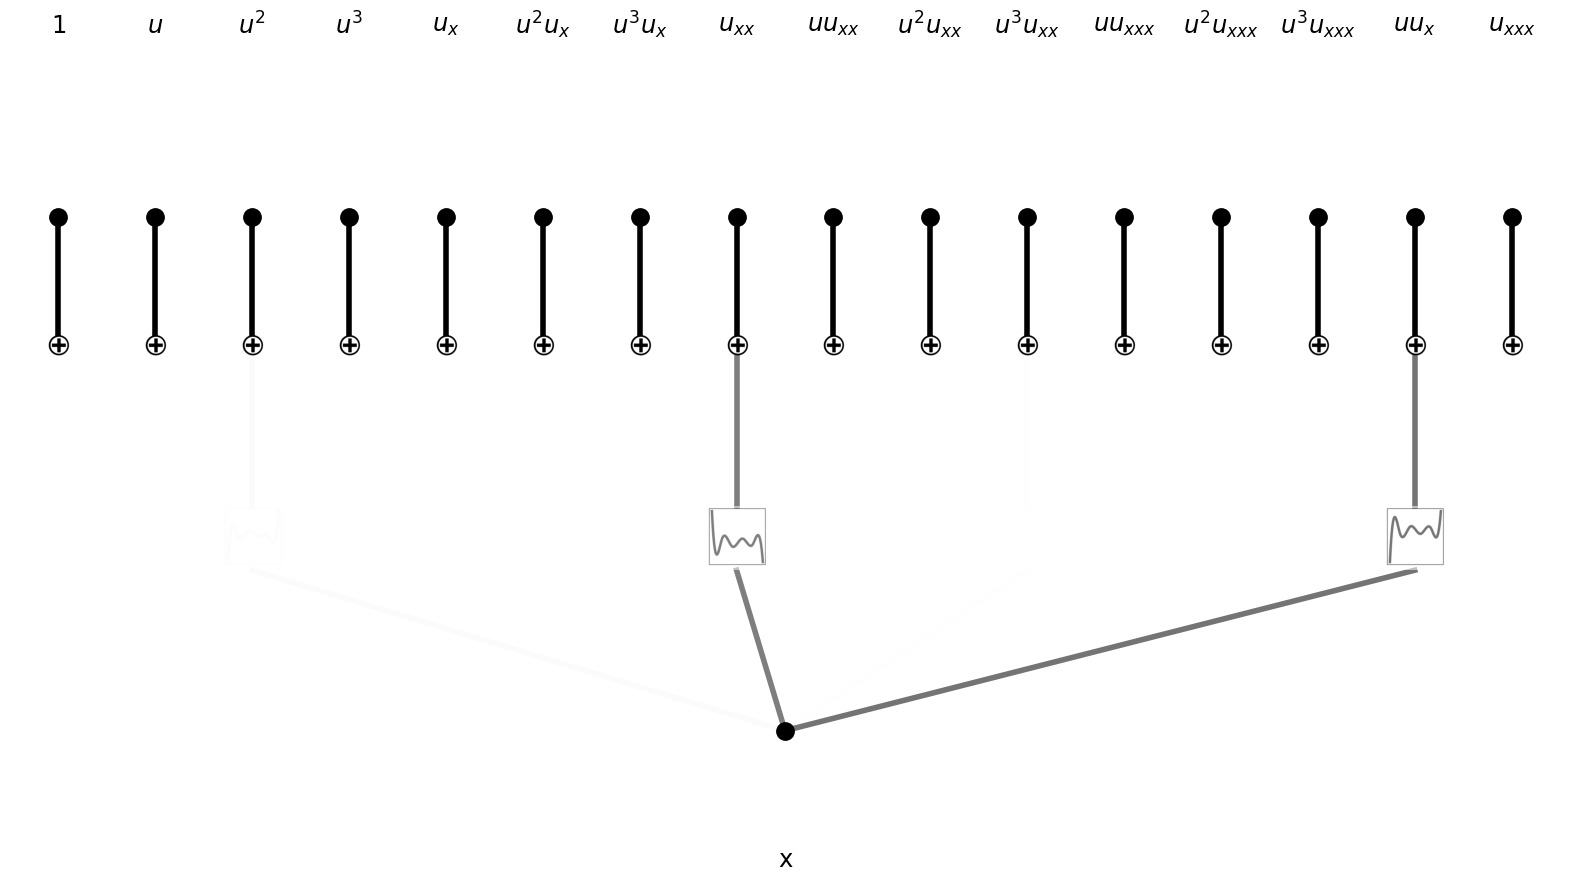

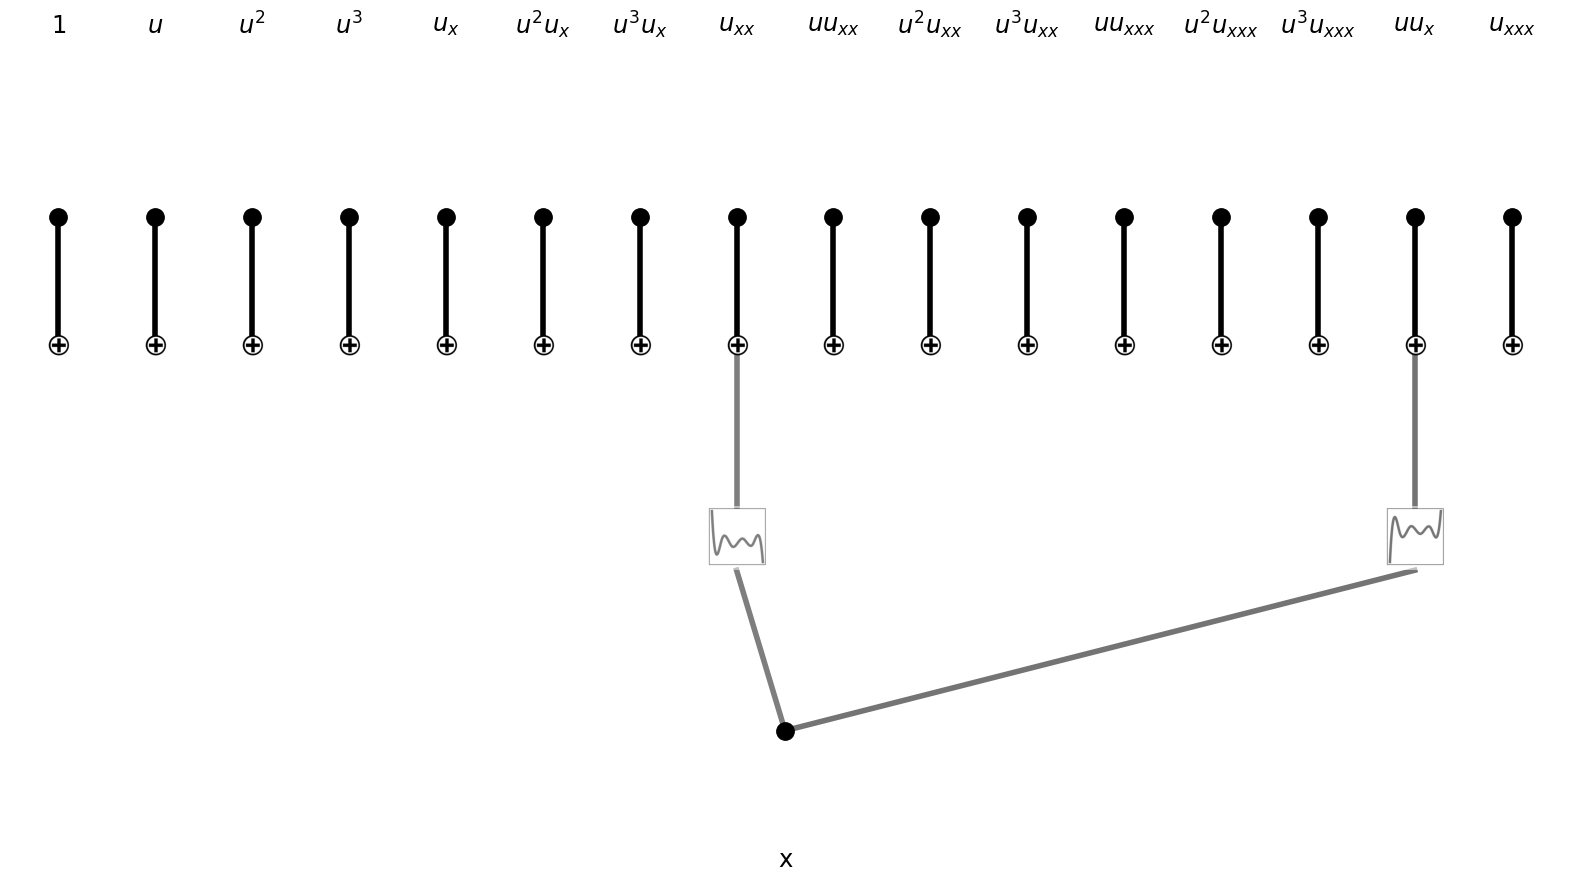

In [14]:
model.prune_kan(input_k)

saving model version 0.2


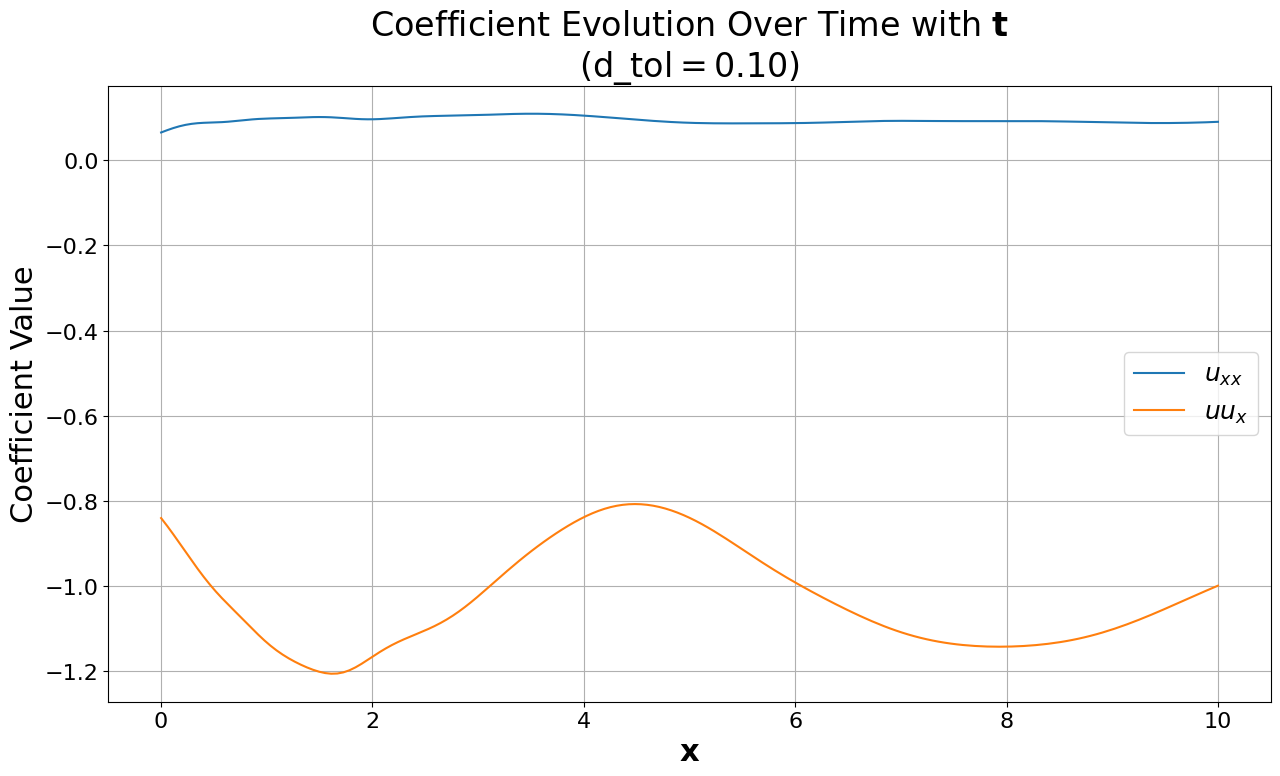

Plot saved as vc_plot/burgers_iter2.pdf


In [15]:
lam = 1e-6
d_tol = 0.1
model.G_STRidge(input_k=input_k, x_steps=x_steps, t_steps=t_steps, d_tol=d_tol, lam=lam)
t = torch.linspace(0,10,t_steps)
model.ridge_plot(d_tol, t, filename='burgers_iter2')

  0%|          | 0/200 [00:00<?, ?it/s]

Training on cuda


 34%|███▍      | 69/200 [08:33<17:37,  8.07s/it, loss=-7.85, loss_data=0.000384, loss_pde=7.8e-6, loss_reg=0.836] Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f3f4047daf0>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/pykan-env/lib/python3.9/site-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 
 36%|███▌      | 71/200 [08:56<16:15,  7.56s/it, loss=-7.85, loss_data=0.000383, loss_pde=7.96e-6, loss_reg=0.838]


KeyboardInterrupt: 

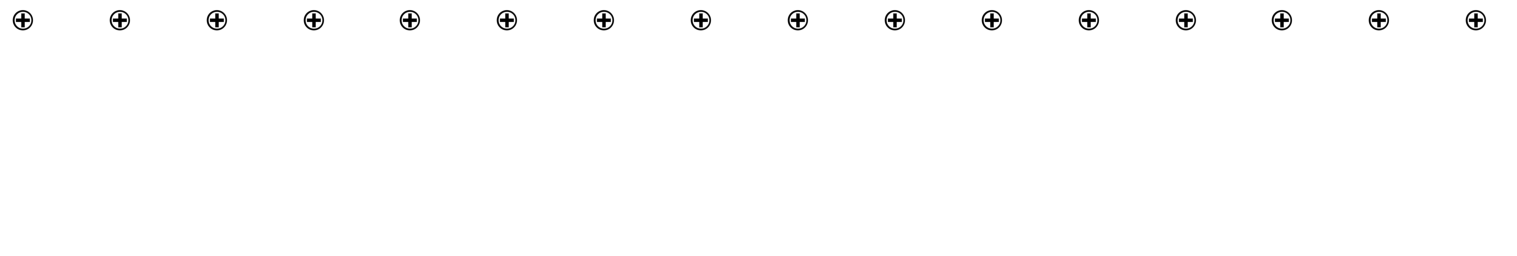

In [20]:
model.fit(input_r, input_k, U, steps=200, alpha=1, lam=0.0, lamb_l1=1., lamb_coef=1, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all', save_fig=True, img_folder='./tem_file3')

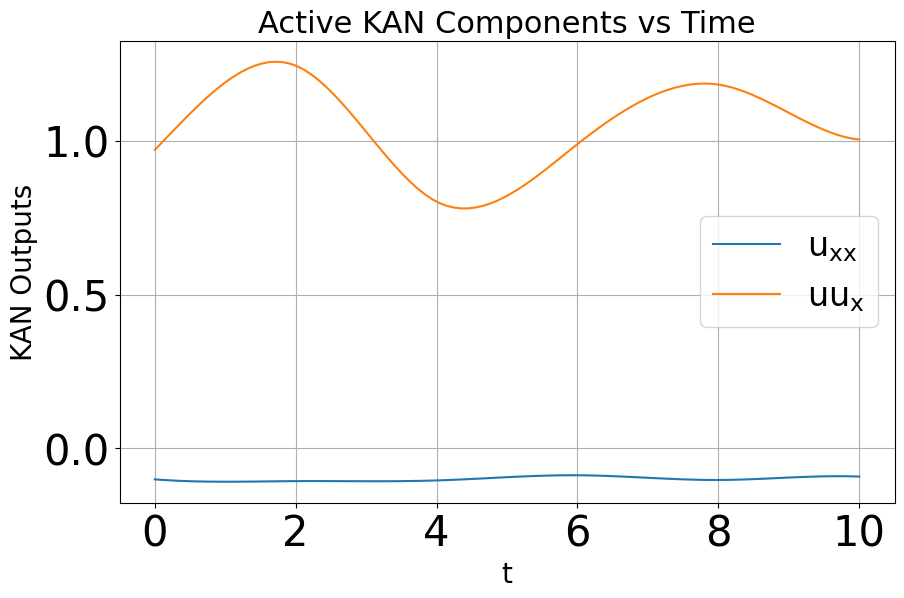

In [22]:
model.plot_kan_components()

In [25]:
model.kan.fix_symbolic(0,0,7,'x')
model.kan.fix_symbolic(0,0,14,'sin')

r2 is 0.46982768177986145
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3
r2 is 0.9435796737670898
saving model version 0.4


-100000000.0

In [27]:
model.fit(input_r, input_k, U, steps=120, alpha=1, lam=0.00, lamb_l1=1., lamb_coef=1, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all')

  0%|          | 0/120 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 120/120 [06:08<00:00,  3.07s/it, loss=-9.24, loss_data=9.49e-5, loss_pde=2.44e-6, loss_reg=0.321]


In [28]:
model.kan.symbolic_formula()[0]

[0.000143718731123954,
 -0.00184783537406474,
 0.00701427878811955,
 -0.00654666638001800,
 -0.00625397404655814,
 -0.0349261164665222,
 -0.0501481480896473,
 0.00116298687829983*x_1 - 0.105893683209163,
 -0.000324024469591677,
 0.0201482232660055,
 -0.0240205787122250,
 -0.000967051368206739,
 -0.0132662430405617,
 0.0182334743440151,
 0.236986950039864*sin(0.995317161083221*x_1 + 0.054752841591835) + 1.03693270683289,
 -0.000508237630128860]

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Active Indices: [ 7 14]


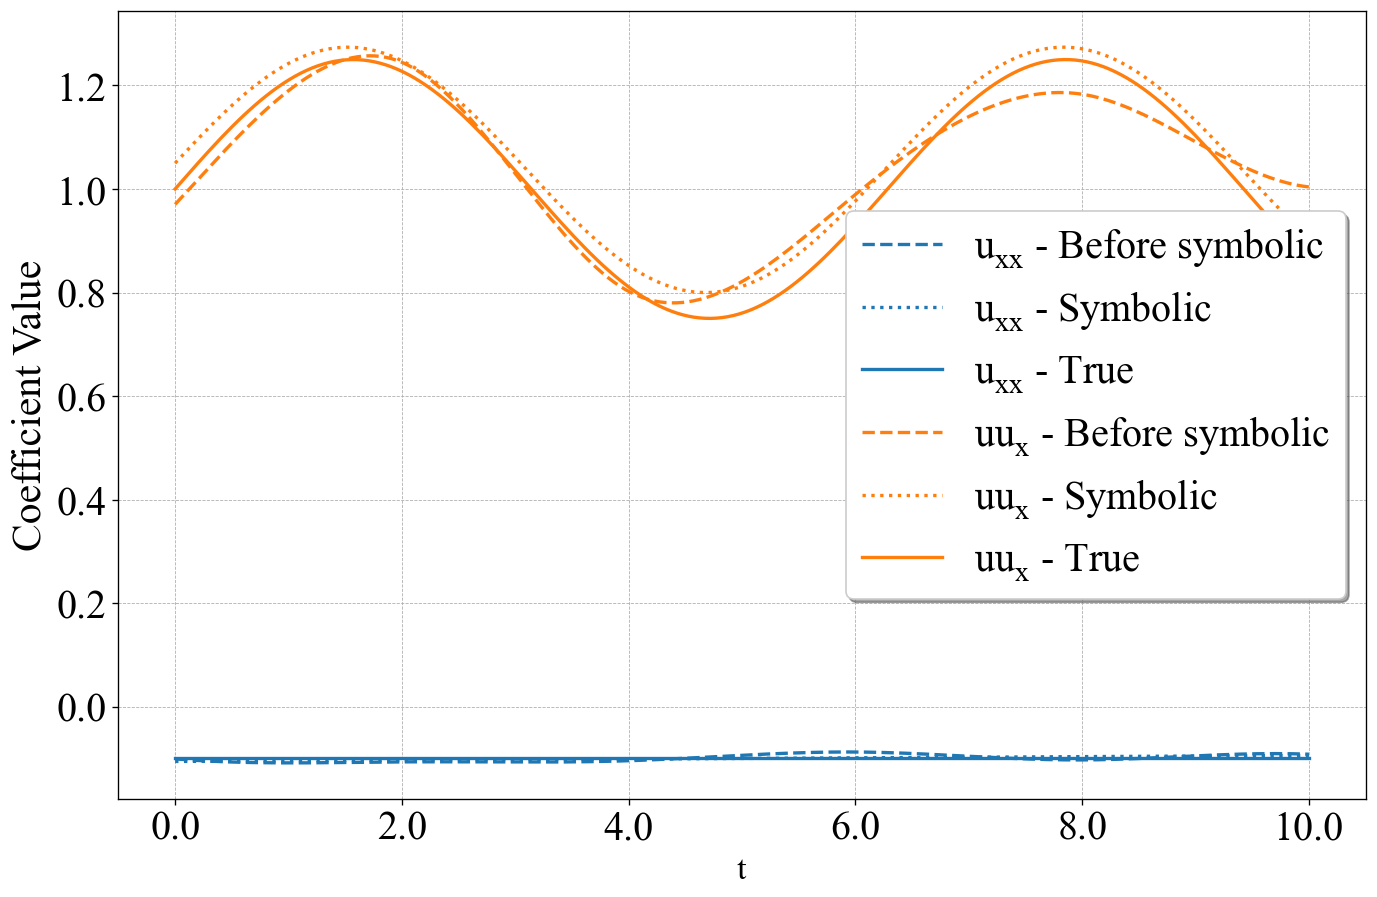

In [29]:
f = lambda t: -0.1 * np.ones_like(t)
g = lambda t: 0.25*np.sin(t) + np.ones_like(t)
true_sol = {
    7: f,
    14: g
}

org_model = VC_PIKAN(Nd=Nd, Nh=Nh, Nb=Nb, rhs_des=rhs_des, range_x=x_range, range_t=t_range, seed=6666, device=device)
org_model.load_state_dict(torch.load('burgers4.pt'))

plot_variable_coefficients(org_model, model, true_sol, x_range, t_range, save_fig=True, file_name='burgers_0.1')